In [1]:
import nashpy as nash
import numpy as np
from itertools import permutations
import time
import math
import pandas as pd
from dataclasses import dataclass
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from adjustText import adjust_text


In [2]:
def generate_unique_distributions(N, M):
    """
    Generate all unique distributions of N identical soldiers into M armies,
    treating distributions that are permutations of each other as identical.
    Each distribution is sorted in non-decreasing order.
    """
    def backtrack(remaining, slots, current):
        if slots == 1:
            yield current + [remaining]
        else:
            for i in range(remaining + 1):
                yield from backtrack(remaining - i, slots - 1, current + [i])

    unique_distributions = set()
    for dist in backtrack(N, M, []):
        sorted_dist = tuple(sorted(dist))
        unique_distributions.add(sorted_dist)
    return sorted(unique_distributions)

In [3]:
def build_payoff_matrix(row_strategies, col_strategies):
    """
    Build the payoff matrix for the Blotto game.
    Payoff is from the row player's perspective and averaged over all permutations
    of the column player's strategy.
    """
    data = [(original_list, list(perm)) for original_list in col_strategies for perm in set(permutations(original_list))]
    permutation_df =  pd.DataFrame(data, columns=["Original List", "Permutation"])
    row_df = pd.DataFrame({'Row List': col_strategies})

    max_len = max(len(lst) for lst in permutation_df["Original List"])
    for i in range(max_len):
        permutation_df[f"Permutation_{i}"] = permutation_df["Permutation"].apply(lambda x: x[i] if i < len(x) else np.nan)
        row_df[f"Row_{i}"] = row_df["Row List"].apply(lambda x: x[i] if i < len(x) else np.nan)

    perm_cols = [f"Permutation_{i}" for i in range(max_len)]
    row_cols = [f"Row_{i}" for i in range(max_len)]

    combinations_df = pd.merge(permutation_df, row_df, how='cross')

    combinations_df['num_win'] = ((combinations_df[perm_cols].values - combinations_df[row_cols].values) > 0).sum(axis=1)
    combinations_df['num_lost'] = ((combinations_df[perm_cols].values - combinations_df[row_cols].values) < 0).sum(axis=1)
    combinations_df['result'] = combinations_df['num_win'] - combinations_df['num_lost']

    final_result = combinations_df.groupby(['Original List', 'Row List'])['result'].mean()
    final_result = final_result.unstack()
    return final_result

In [6]:
N = 100
M = 3

strategies = generate_unique_distributions(N, M)
A = build_payoff_matrix(strategies, strategies)

game = nash.Game(A)
p1, p2 = game.linear_program()

for strat, prob in zip(strategies, p1):
    if prob > 0:
        print(strat, np.round(prob, decimals=4))

(0, 33, 67) 0.0294
(0, 36, 64) 0.0
(0, 41, 59) 0.0294
(1, 46, 53) 0.0264
(1, 49, 50) 0.003
(2, 36, 62) 0.0118
(2, 37, 61) 0.0079
(2, 40, 58) 0.0335
(2, 45, 53) 0.003
(2, 46, 52) 0.0027
(3, 42, 55) 0.0294
(4, 37, 59) 0.0
(4, 39, 57) 0.0286
(4, 40, 56) 0.0107
(4, 42, 54) 0.0196
(5, 30, 65) 0.0226
(5, 31, 64) 0.0068
(6, 28, 66) 0.0188
(6, 36, 58) 0.0253
(6, 47, 47) 0.0147
(7, 27, 66) 0.0114
(7, 29, 64) 0.0094
(7, 44, 49) 0.0086
(8, 32, 60) 0.0282
(8, 44, 48) 0.0306
(9, 28, 63) 0.0137
(9, 42, 49) 0.0074
(9, 43, 48) 0.0083
(10, 30, 60) 0.0027
(10, 38, 52) 0.0562
(11, 26, 63) 0.0002
(11, 28, 61) 0.0215
(11, 32, 57) 0.0009
(11, 44, 45) 0.0068
(12, 34, 54) 0.027
(12, 37, 51) 0.0131
(12, 43, 45) 0.0187
(13, 23, 64) 0.0062
(13, 27, 60) 0.0148
(13, 37, 50) 0.0084
(14, 21, 65) 0.0068
(14, 24, 62) 0.0302
(14, 36, 50) 0.0218
(15, 19, 66) 0.0139
(15, 25, 60) 0.0131
(15, 42, 43) 0.0024
(16, 20, 64) 0.0363
(16, 22, 62) 0.0168
(16, 28, 56) 0.0048
(16, 39, 45) 0.0009
(17, 17, 66) 0.0147
(18, 19, 63) 0.01

In [8]:
df = pd.DataFrame({
    'strategies': strategies,
    'probabilities': p1})

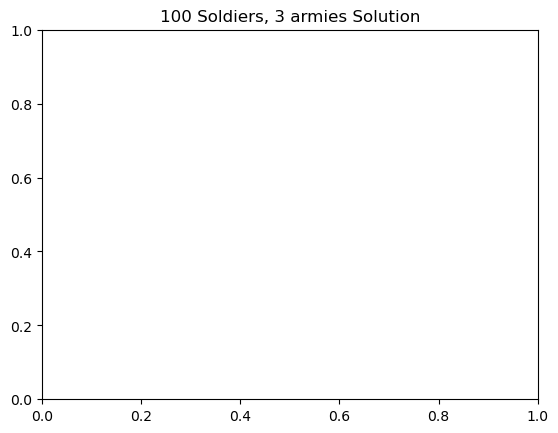

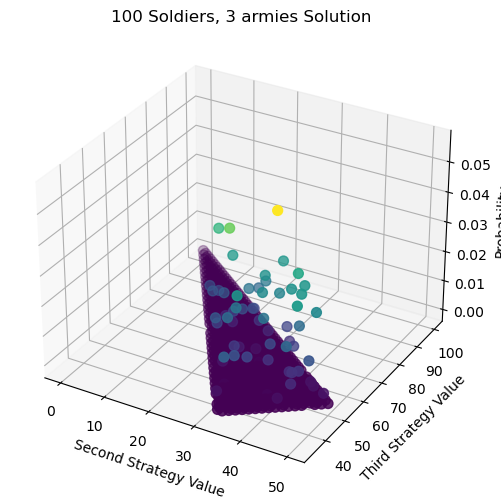

In [31]:
plt.close('all')
x = np.array([s[1] for s in df["strategies"]])
y = np.array([s[2] for s in df["strategies"]])
z = np.array(df["probabilities"])

# Create 3D Scatter Plot
plt.title('100 Soldiers, 3 armies Solution')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(x, y, z, c=z, cmap="viridis", s=50)

ax.set_xlabel("Second Strategy Value")
ax.set_ylabel("Third Strategy Value")
ax.set_zlabel("Probability")
plt.title('100 Soldiers, 3 armies Solution');
plt.show()

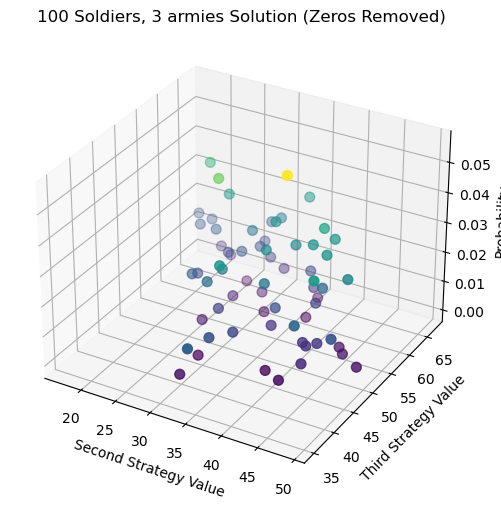

In [32]:
plt.close('all')
filtered_df = df[df['probabilities'] > 0]
x = np.array([s[1] for s in filtered_df["strategies"]])
y = np.array([s[2] for s in filtered_df["strategies"]])
z = np.array(filtered_df["probabilities"])

# Create 3D Scatter Plot

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(x, y, z, c=z, cmap="viridis", s=50)

ax.set_xlabel("Second Strategy Value")
ax.set_ylabel("Third Strategy Value")
ax.set_zlabel("Probability")
plt.title('100 Soldiers, 3 armies Solution (Zeros Removed)');

In [38]:
df[df['probabilities'] > 0].sort_values(by='probabilities', ascending=False).head(20)

,strategies,probabilities
468,"(10, 38, 52)",0.056158
692,"(18, 26, 56)",0.043321
636,"(16, 20, 64)",0.036336
138,"(2, 40, 58)",0.033517
400,"(8, 44, 48)",0.030576
584,"(14, 24, 62)",0.030239
780,"(22, 32, 46)",0.029718
187,"(3, 42, 55)",0.029412
33,"(0, 33, 67)",0.029412
41,"(0, 41, 59)",0.029412


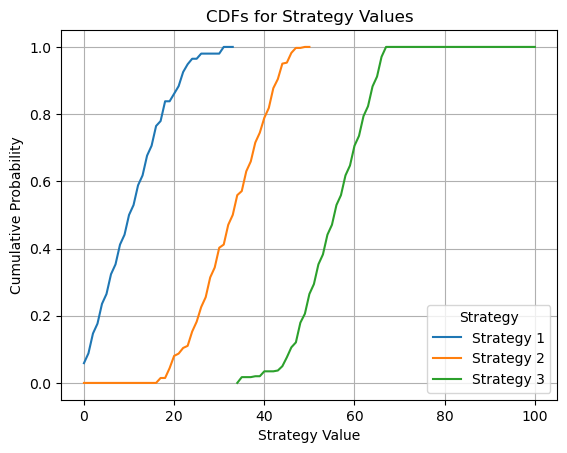

In [53]:
COLORS = sns.color_palette("tab10", 3)
df[["strategy_1", "strategy_2", "strategy_3"]] = pd.DataFrame(df["strategies"].tolist(), index=df.index)
for i, s in enumerate(["strategy_1", "strategy_2", "strategy_3"]):
    grouped = df.groupby(s)["probabilities"].sum().reset_index()
    grouped.sort_values(by=s)
    grouped['cdf'] = grouped['probabilities'].cumsum()
    sns.lineplot(data=grouped, x=s, y='cdf', color=COLORS[i], label=s.replace("_", " ").title())

plt.xlabel("Strategy Value")
plt.ylabel("Cumulative Probability")
plt.title("CDFs for Strategy Values")
plt.legend(title="Strategy")
plt.grid()

In [45]:
df.head(50)

,strategies,probabilities,strategy_1,strategy_2,strategy_3,cdf_strategy_1,cdf_strategy_2,cdf_strategy_3
883,"(33, 33, 34)",0.000000,33,33,34,1.000000,0.500000,0.000000
882,"(32, 34, 34)",0.000000,32,34,34,1.000000,0.541575,0.000000
875,"(30, 35, 35)",0.000000,30,35,35,0.980086,0.570987,0.000000
879,"(31, 34, 35)",0.017249,31,34,35,1.000000,0.558824,0.017249
881,"(32, 33, 35)",0.000000,32,33,35,1.000000,0.500000,0.017249
869,"(29, 35, 36)",0.000000,29,35,36,0.980086,0.570987,0.017249
874,"(30, 34, 36)",0.000000,30,34,36,0.980086,0.558824,0.017249
880,"(32, 32, 36)",0.000000,32,32,36,1.000000,0.440012,0.017249
878,"(31, 33, 36)",0.000000,31,33,36,0.982751,0.500000,0.017249
862,"(28, 36, 36)",0.000000,28,36,36,0.980086,0.618045,0.017249
